In [80]:
import yfinance as yf
import pandas as pd
import csv
import datetime as dt
from datetime import datetime # To get the current date and time
from datetime import date, timedelta
import csv
import time
import os
import pandas as pd
from functools import reduce

In [81]:
ticker_data = pd.read_csv('bonds.csv')
tickers_list = ticker_data['Symbol'].tolist() # Get all the tickers in a list

In [82]:
tickers_list

['IGLB',
 'MBB',
 'SHY',
 'SJNK',
 'SPAB',
 'USHY',
 'VCSH',
 'VGLT',
 'IGLB',
 'MBB',
 'SJNK',
 'SPAB',
 'USHY',
 'VCSH',
 'VGLT']

In [83]:
def get_OHLC_data(tickers, start_date = None, end_date = None):
    '''
    This function gets daily OHLC data from Yahoo Finance API for the provided number of days. 
    In case days is not provided then data is pulled for maximum number of days
    
    Input Parameters: 
    tickers: List of tickers for which data needs to be extracted
    Start Date: Date from which data needs to be pulled
    End Date: Date until which data needs to be pulled
    If start and end date is null then data for maximum number of days is pulled
    
    Returns: Dataframe of the extracted data
    '''
    final_OHLC_df = pd.DataFrame() # Declare the final empty dataframe
    for ticker in tickers: # For each stock symbol in the list of symbols
        OHLC_data = pd.DataFrame() # Declare intermediate data frame
        
        yf_ticker_obj = yf.Ticker(ticker) # Initiate object to get the data from API
        
        # If start date and end date is provided then pull data for those days
        if(start_date != None and end_date != None): 
            OHLC_data = yf_ticker_obj.history(start = start_date, end = end_date, interval = "1d", auto_adjust = True)
        
        else: # Pull data for all the available days
            OHLC_data = yf_ticker_obj.history(period="max", interval = "1d", auto_adjust = True)
        # Note: In the above period = 'max' as we are pulling data for maximum number of days.
        # interval = '1d' as per pulling daily data for Open, High, Low, Close and Volume
        # auto_adjust = 'True' as we are adjusting data for Dividends and Splits
        
        OHLC_data.insert(0, 'Symbol', ticker) # Adding this data to dataframe
        # Delete split and dividend columns as this is not required.
        
        OHLC_data = OHLC_data.drop(['Dividends','Stock Splits'], axis=1, errors='ignore')
        
        # Apppending this data to final dataframe
        final_OHLC_df = final_OHLC_df.append(OHLC_data)
        time.sleep(.5)
    
    final_OHLC_df.reset_index(inplace=True) # Re-setting the index
    
    # Setting index to symbol and date
    final_OHLC_df.set_index(["Date", "Symbol"], inplace=True)
    return final_OHLC_df

In [84]:
def get_last_date_data(file):
    '''
    This function open existing OHLC file, put that in pandas dataframe and extract the last date from the file
    Input Parameters: Name of the existing csv file that needs to be read in dataframe
    Returns: Last date and pandas dataframe containing the data in the file
    '''
    old_data_df = pd.read_csv(file) # Read the csv file in a dataframe

    # Convert Date column to datetime
    old_data_df['Date']= pd.to_datetime(old_data_df['Date'])
    
    # Get the maximum date which is the last date for which data is present
    previous_date = max(old_data_df['Date']) 
    
    # Converting datetime to only date format as for daily OHLC data we don't need time
    old_data_df['Date'] = old_data_df['Date'].dt.date
    
    # Set dataframe index to Date and Symbol
    old_data_df.set_index(["Date", "Symbol"], inplace=True)
    return previous_date, old_data_df

In [85]:
if __name__ == "__main__":
    
    # tickers_list = ['AAPL', 'MSFT'] # Created for testing. Test the script on 2 symbols instead of 500
    # Get the next date in YYYY-MM-DD format. 
    # Yfinance API gives data from last day if today's date is entered as start date
    today = pd.Timestamp.now().normalize() # Today's date
    next_day =  today + timedelta(days=1) # Adding 1 to get next date
   
    # Name of the output file
    OHLC_data_file = "OHLC_yfinance_data.csv"
       
    # Check if the OHLC csv file existing the root folder from where this script is ran
    if os.path.isfile(OHLC_data_file):
        
        # Get the latest date in the datafile and load data in pandas dataframe
        previous_day, old_data_df = get_last_date_data(OHLC_data_file)
        
        # Get the data from latest date in the old file to todays date
        latest_data = get_OHLC_data(tickers_list, previous_day, next_day)
        
        # Append new data with old data
        final_df = old_data_df.append(latest_data)
        
        # Reset index and remove duplicates
        final_df.reset_index(inplace=True)
        # Drop duplicates that has same symbol and date
        final_df = final_df.drop_duplicates(subset=['Date', 'Symbol'], keep='first')
        
        # Set index to symbol and date
        final_df.set_index(["Date", "Symbol"], inplace=True)
        
    else: # This is done in case we are running script for the first time or data file does not exist
        latest_data = get_OHLC_data(tickers_list) # Get the data for max available time
        final_df = latest_data
    
    if ('Adj Close' in final_df.columns): # Drop adjusted close column if exists
        final_df.drop('Adj Close', axis=1, inplace=True)
    
    # Writing the data to the output csv file
    final_df.to_csv(OHLC_data_file, mode='w', index=True) #index is True as we want it to be written in file
    

C:\Users\max\Miniconda3\lib\site-packages\pandas\core\algorithms.py:1783: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\max\Miniconda3\lib\site-packages\pandas\core\indexes\base.py:2023: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [86]:
bnd=pd.read_csv('OHLC_yfinance_data.csv')

In [87]:
IGLB=bnd.loc[bnd['Symbol'] == 'IGLB']
IGLB=IGLB.rename(columns={ 'Close':'IGLB_close'})
IGLB=IGLB.loc[:, ['Date','IGLB_close']]

In [88]:
MBB=bnd.loc[bnd['Symbol'] == 'MBB']
MBB=MBB.rename(columns={ 'Close':'MBB_close'})
MBB=MBB.loc[:, ['Date','MBB_close']]


In [89]:
SHY=bnd.loc[bnd['Symbol'] == 'SHY']
SHY=SHY.rename(columns={ 'Close':'SHY_close'})
SHY=SHY.loc[:, ['Date','SHY_close']]

In [90]:
SJNK=bnd.loc[bnd['Symbol'] == 'SJNK']
SJNK=SJNK.rename(columns={ 'Close':'SJNK_close'})
SJNK=SJNK.loc[:, ['Date','SJNK_close']]

In [91]:

SPAB=bnd.loc[bnd['Symbol'] == 'SPAB']
SPAB=SPAB.rename(columns={ 'Close':'SPAB_close'})
SPAB=SPAB.loc[:, ['Date','SPAB_close']]

In [92]:

USHY=bnd.loc[bnd['Symbol'] == 'USHY']
USHY=USHY.rename(columns={ 'Close':'USHY_close'})
USHY=USHY.loc[:, ['Date','USHY_close']]

In [93]:

VCSH=bnd.loc[bnd['Symbol'] == 'VCSH']
VCSH=VCSH.rename(columns={ 'Close':'VCSH_close'})
VCSH=VCSH.loc[:, ['Date','VCSH_close']]

In [94]:


VGLT=bnd.loc[bnd['Symbol'] == 'VGLT']
VGLT=VGLT.rename(columns={ 'Close':'VGLT_close'})
VGLT=VGLT.loc[:, ['Date','VGLT_close']]

In [95]:
data_frames=[VGLT,VCSH,USHY,SPAB,SJNK,SHY,MBB,IGLB]

In [96]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), data_frames)

In [97]:
df=df_merged.sort_values(by='Date',ascending=True)

In [98]:
df

,Date,VGLT_close,VCSH_close,USHY_close,SPAB_close,SJNK_close,SHY_close,MBB_close,IGLB_close
3705,2002-07-30,NaN,NaN,NaN,NaN,NaN,58.722919,NaN,NaN
3706,2002-07-31,NaN,NaN,NaN,NaN,NaN,58.904144,NaN,NaN
3707,2002-08-01,NaN,NaN,NaN,NaN,NaN,59.020180,NaN,NaN
3708,2002-08-02,NaN,NaN,NaN,NaN,NaN,59.136143,NaN,NaN
3709,2002-08-05,NaN,NaN,NaN,NaN,NaN,59.230320,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3045,2022-02-07,84.269997,79.980003,39.580002,28.740000,26.580000,84.720001,105.120003,64.610001
3046,2022-02-08,83.709999,79.860001,39.540001,28.650000,26.559999,84.629997,104.860001,64.230003
3047,2022-02-09,83.839996,79.849998,39.750000,28.680000,26.660000,84.620003,104.699997,64.370003
3048,2022-02-10,82.610001,79.379997,39.209999,28.370001,26.440001,84.190002,103.800003,63.450001


In [99]:
df=df.dropna()

In [100]:
df

,Date,VGLT_close,VCSH_close,USHY_close,SPAB_close,SJNK_close,SHY_close,MBB_close,IGLB_close
1968,2017-10-26,68.320992,72.045609,39.532856,25.652668,22.223160,79.838272,97.153336,52.415199
1969,2017-10-27,68.709923,72.117767,39.422466,25.697319,22.263046,79.895111,97.354073,52.653286
1970,2017-10-30,69.361153,72.153839,39.540726,25.759853,22.271021,79.933029,97.573082,52.942413
1971,2017-10-31,69.333984,72.162827,39.564396,25.733057,22.271021,79.885666,97.545708,52.959431
1972,2017-11-01,69.623970,72.111374,39.553356,25.746485,22.277428,79.874275,97.576767,53.024265
...,...,...,...,...,...,...,...,...,...
3045,2022-02-07,84.269997,79.980003,39.580002,28.740000,26.580000,84.720001,105.120003,64.610001
3046,2022-02-08,83.709999,79.860001,39.540001,28.650000,26.559999,84.629997,104.860001,64.230003
3047,2022-02-09,83.839996,79.849998,39.750000,28.680000,26.660000,84.620003,104.699997,64.370003
3048,2022-02-10,82.610001,79.379997,39.209999,28.370001,26.440001,84.190002,103.800003,63.450001


In [101]:
df.set_index('Date', inplace=True)

In [102]:
df

,VGLT_close,VCSH_close,USHY_close,SPAB_close,SJNK_close,SHY_close,MBB_close,IGLB_close
Date,,,,,,,,
2017-10-26,68.320992,72.045609,39.532856,25.652668,22.223160,79.838272,97.153336,52.415199
2017-10-27,68.709923,72.117767,39.422466,25.697319,22.263046,79.895111,97.354073,52.653286
2017-10-30,69.361153,72.153839,39.540726,25.759853,22.271021,79.933029,97.573082,52.942413
2017-10-31,69.333984,72.162827,39.564396,25.733057,22.271021,79.885666,97.545708,52.959431
2017-11-01,69.623970,72.111374,39.553356,25.746485,22.277428,79.874275,97.576767,53.024265
...,...,...,...,...,...,...,...,...
2022-02-07,84.269997,79.980003,39.580002,28.740000,26.580000,84.720001,105.120003,64.610001
2022-02-08,83.709999,79.860001,39.540001,28.650000,26.559999,84.629997,104.860001,64.230003
2022-02-09,83.839996,79.849998,39.750000,28.680000,26.660000,84.620003,104.699997,64.370003


In [103]:
df['average_all'] = df.mean(axis=1)

C:\Users\max\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
df=df.pct_change()

In [105]:
bnd=bnd.dropna()

In [106]:
dff = bnd.loc[(bnd['Date'] > '2019-1-01')]

In [107]:
df

,VGLT_close,VCSH_close,USHY_close,SPAB_close,SJNK_close,SHY_close,MBB_close,IGLB_close,average_all
Date,,,,,,,,,
2017-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-27,0.005693,0.001002,-0.002792,0.001741,0.001795,0.000712,0.002066,0.004542,0.002036
2017-10-30,0.009478,0.000500,0.003000,0.002433,0.000358,0.000475,0.002250,0.005491,0.003104
2017-10-31,-0.000392,0.000125,0.000599,-0.001040,0.000000,-0.000593,-0.000281,0.000321,-0.000172
2017-11-01,0.004182,-0.000713,-0.000279,0.000522,0.000288,-0.000143,0.000318,0.001224,0.000722
...,...,...,...,...,...,...,...,...,...
2022-02-07,0.000950,0.001252,-0.000253,0.000696,0.000000,0.000236,0.001048,0.002794,0.000974
2022-02-08,-0.006645,-0.001500,-0.001011,-0.003132,-0.000752,-0.001062,-0.002473,-0.005881,-0.003037
2022-02-09,0.001553,-0.000125,0.005311,0.001047,0.003765,-0.000118,-0.001526,0.002180,0.000840


In [108]:
dff.set_index('Date', inplace=True)

In [109]:
pctchange=df.dropna()

In [110]:
pctchange.reset_index(inplace=True)

In [111]:
pctchange

,Date,VGLT_close,VCSH_close,USHY_close,SPAB_close,SJNK_close,SHY_close,MBB_close,IGLB_close,average_all
0,2017-10-27,0.005693,0.001002,-0.002792,0.001741,0.001795,0.000712,0.002066,0.004542,0.002036
1,2017-10-30,0.009478,0.000500,0.003000,0.002433,0.000358,0.000475,0.002250,0.005491,0.003104
2,2017-10-31,-0.000392,0.000125,0.000599,-0.001040,0.000000,-0.000593,-0.000281,0.000321,-0.000172
3,2017-11-01,0.004182,-0.000713,-0.000279,0.000522,0.000288,-0.000143,0.000318,0.001224,0.000722
4,2017-11-02,0.004425,-0.000251,-0.000718,0.001739,-0.000719,0.000237,0.000094,0.002575,0.000990
...,...,...,...,...,...,...,...,...,...,...
1076,2022-02-07,0.000950,0.001252,-0.000253,0.000696,0.000000,0.000236,0.001048,0.002794,0.000974
1077,2022-02-08,-0.006645,-0.001500,-0.001011,-0.003132,-0.000752,-0.001062,-0.002473,-0.005881,-0.003037
1078,2022-02-09,0.001553,-0.000125,0.005311,0.001047,0.003765,-0.000118,-0.001526,0.002180,0.000840
1079,2022-02-10,-0.014671,-0.005886,-0.013585,-0.010809,-0.008252,-0.005082,-0.008596,-0.014292,-0.009796


In [112]:
pctchange.to_csv('pctchnge.csv')

In [113]:
df.plot.line()
ax = df.plot.line()

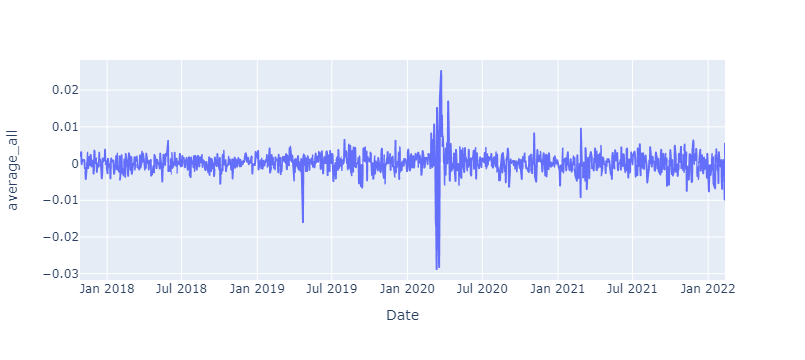

In [114]:
import plotly.express as px
fig = px.line(pctchange, x="Date", y="average_all")
fig.show()

In [115]:
bnd

,Date,Symbol,Open,High,Low,Close,Volume
0,2009-12-09,IGLB,30.744227,30.744227,30.665907,30.665907,10200
1,2009-12-10,IGLB,30.665907,30.665907,30.665907,30.665907,0
2,2009-12-11,IGLB,30.286349,30.461067,30.286349,30.461067,4400
3,2009-12-14,IGLB,30.635785,30.647835,30.635785,30.647835,500
4,2009-12-15,IGLB,30.647835,30.647835,30.647835,30.647835,0
...,...,...,...,...,...,...,...
25132,2022-02-07,VGLT,84.160004,84.370003,83.940002,84.269997,1896500
25133,2022-02-08,VGLT,83.760002,83.940002,83.519997,83.709999,2399600
25134,2022-02-09,VGLT,84.029999,84.410004,83.750000,83.839996,3887100
25135,2022-02-10,VGLT,83.430000,83.529999,82.410004,82.610001,5769800


In [116]:
import requests
from datetime import datetime
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import talib


In [117]:
from fredapi import Fred
fred = Fred(api_key='fd961227770e7d1b0055b62956eaf6a3')
spread = fred.get_series('T10Y2Y')

In [118]:
from fredapi import Fred
fred = Fred(api_key='fd961227770e7d1b0055b62956eaf6a3')
dominv = fred.get_series('W790RC1Q027SBEA')

In [119]:
dominv

1960-01-01     29.189
1960-04-01     21.476
1960-07-01     21.359
1960-10-01     10.833
1961-01-01     13.205
               ...   
2020-10-01    489.007
2021-01-01    422.955
2021-04-01    374.530
2021-07-01    461.186
2021-10-01    732.110
Length: 248, dtype: float64

In [120]:
spread

1976-06-01    0.68
1976-06-02    0.71
1976-06-03    0.70
1976-06-04    0.77
1976-06-07    0.79
              ... 
2022-02-07    0.62
2022-02-08    0.61
2022-02-09    0.58
2022-02-10    0.42
2022-02-11    0.42
Length: 11924, dtype: float64

In [121]:
from fredapi import Fred
fred = Fred(api_key='fd961227770e7d1b0055b62956eaf6a3')
inflation = fred.get_series('T10YIE')

In [122]:
inflation

2003-01-02    1.64
2003-01-03    1.62
2003-01-06    1.63
2003-01-07    1.62
2003-01-08    1.71
              ... 
2022-02-07    2.40
2022-02-08    2.42
2022-02-09    2.42
2022-02-10    2.45
2022-02-11    2.43
Length: 4987, dtype: float64

In [141]:
from fredapi import Fred
fred = Fred(api_key='fd961227770e7d1b0055b62956eaf6a3')
balance = fred.get_series('TREAST')

In [142]:
df = pd.DataFrame(spread)
df.columns = ['spread']

In [143]:
df

,spread
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79
...,...
2022-02-07,0.62
2022-02-08,0.61
2022-02-09,0.58
2022-02-10,0.42


In [144]:
df1=pd.DataFrame(inflation)
df1.columns = ['inflation']

In [145]:
df2=pd.DataFrame(balance)
df2.columns = ['balance']

In [146]:
df

,spread
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79
...,...
2022-02-07,0.62
2022-02-08,0.61
2022-02-09,0.58
2022-02-10,0.42


In [147]:
df=pd.merge(df1, df, left_index=True, right_index=True)

In [148]:
df=pd.merge(df2,df, left_index=True, right_index=True)

In [149]:
df=df.pct_change()

In [150]:
df.reset_index(inplace=True)

In [151]:
df.rename(columns = {'index':'Date'}, inplace = True)

In [152]:
df

,Date,balance,inflation,spread
0,2003-01-08,NaN,NaN,NaN
1,2003-01-15,0.000000,0.052632,0.026201
2,2003-01-22,0.000000,-0.044444,-0.025532
3,2003-01-29,0.000000,0.075581,0.000000
4,2003-02-05,-0.000008,0.027027,0.000000
...,...,...,...,...
992,2022-01-12,0.004144,-0.019763,-0.068182
993,2022-01-19,0.001514,-0.032258,-0.036585
994,2022-01-26,0.004018,-0.008333,-0.088608
995,2022-02-02,0.002080,0.012605,-0.138889


In [153]:
df=df.dropna()

In [154]:
pctchange

,Date,VGLT_close,VCSH_close,USHY_close,SPAB_close,SJNK_close,SHY_close,MBB_close,IGLB_close,average_all
0,2017-10-27,0.005693,0.001002,-0.002792,0.001741,0.001795,0.000712,0.002066,0.004542,0.002036
1,2017-10-30,0.009478,0.000500,0.003000,0.002433,0.000358,0.000475,0.002250,0.005491,0.003104
2,2017-10-31,-0.000392,0.000125,0.000599,-0.001040,0.000000,-0.000593,-0.000281,0.000321,-0.000172
3,2017-11-01,0.004182,-0.000713,-0.000279,0.000522,0.000288,-0.000143,0.000318,0.001224,0.000722
4,2017-11-02,0.004425,-0.000251,-0.000718,0.001739,-0.000719,0.000237,0.000094,0.002575,0.000990
...,...,...,...,...,...,...,...,...,...,...
1076,2022-02-07,0.000950,0.001252,-0.000253,0.000696,0.000000,0.000236,0.001048,0.002794,0.000974
1077,2022-02-08,-0.006645,-0.001500,-0.001011,-0.003132,-0.000752,-0.001062,-0.002473,-0.005881,-0.003037
1078,2022-02-09,0.001553,-0.000125,0.005311,0.001047,0.003765,-0.000118,-0.001526,0.002180,0.000840
1079,2022-02-10,-0.014671,-0.005886,-0.013585,-0.010809,-0.008252,-0.005082,-0.008596,-0.014292,-0.009796


In [155]:
pctchange['Date'] = pd.to_datetime(
                          pctchange['Date'])

C:\Users\max\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [156]:
data_frames=[df,pctchange]

In [157]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), data_frames)

In [158]:
df_merged.dropna()

,Date,balance,inflation,spread,VGLT_close,VCSH_close,USHY_close,SPAB_close,SJNK_close,SHY_close,MBB_close,IGLB_close,average_all
772,2017-11-01,-0.002393,0.000000,-0.084337,0.004182,-0.000713,-0.000279,0.000522,0.000288,-0.000143,0.000318,0.001224,0.000722
773,2017-11-08,0.000064,-0.005319,-0.118421,-0.002438,-0.000751,-0.004783,0.000000,-0.003603,-0.000119,-0.000935,-0.000641,-0.001367
774,2017-11-15,-0.001359,-0.010695,-0.029851,0.010770,0.000628,0.000000,0.002436,0.001092,-0.000356,0.001595,0.006649,0.002968
775,2017-11-22,0.000074,-0.005405,-0.107692,0.003464,0.002262,0.000000,0.003129,0.001806,0.000833,0.002439,0.004956,0.002382
776,2017-11-29,0.000056,0.000000,0.017241,-0.009484,-0.001003,0.000000,-0.001734,-0.000360,-0.000237,-0.001030,-0.006369,-0.002724
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,2022-01-12,0.004144,-0.019763,-0.068182,-0.003113,-0.000124,0.000979,0.000342,0.000737,-0.000352,-0.000752,-0.000885,-0.000725
992,2022-01-19,0.001514,-0.032258,-0.036585,0.006723,0.000000,-0.000740,0.001727,-0.000370,0.000470,0.003324,0.002113,0.002142
993,2022-01-26,0.004018,-0.008333,-0.088608,-0.010816,-0.002732,-0.003724,-0.004816,-0.002232,-0.001762,-0.005286,-0.008144,-0.005287
994,2022-02-02,0.002080,0.012605,-0.138889,0.003382,0.000748,0.000749,0.001036,0.000000,0.000236,0.000852,-0.000454,0.000945


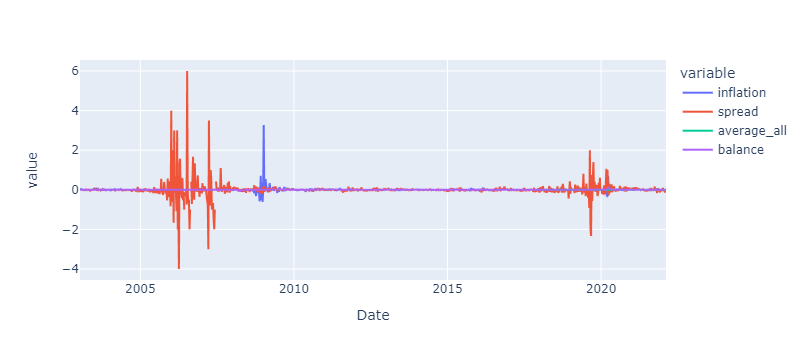

In [160]:
import plotly.express as px 
import pandas as pd 
import numpy as np 
import os

# data


df_long=pd.melt(df_merged , id_vars=['Date'], value_vars=['inflation','spread','average_all','balance'])

fig = px.line(df_long, x='Date', y='value', color='variable')
fig.show()

In [72]:
import plotly.express as px
fig1 = px.line(df_merged, x="Date", y=)
fig1.show()

SyntaxError: invalid syntax (<ipython-input-72-faf055fc6d5e>, line 2)

In [ ]:
import plotly.express as px
fig2 = px.line(df, x="Date", y="spread",color="inflation")
fig2.show()